### Movie Recommendations 

Predict how a user would rate a movie

Generate Ratings and present the recommendation list

In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import re

import boto3
from sagemaker import get_execution_role
import sagemaker

#SDK 2
from sagemaker.deserializers import JSONDeserializer

In [64]:
# Create predictor from existing endpoint

endpoint_name='fm-movie-v4'
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [9]:
# Read dimension: number of unique columns
dim_movie
with open(r'ml-latest-small/movie_dimension.txt','r') as f:
    dim_movie = int(f.read())

In [10]:
dim_movie

10334

In [63]:
# Custom serializer

def fm_sparse_serializer(data):
    js = {'instances':[]}
    for row in data:
        
        column_list=row.tolist()
        value_list = np.ones(len(column_list), dtype=int).tolist()
        
        js['instances'].append(
            {
                "data": {
                    "features": {
                        'keys':column_list, 
                        'shape':[dim_movie], 
                        'values':value_list
                                }         
                        }
            }
        )
    
    return json.dumps(js)
    

In [65]:
# specify custom serializer

predictor.serializer.serialize = fm_sparse_serializer
predictor.serializer.content_type='application/json'

predictor.deserializer = JSONDeserializer()

In [7]:
predictor

In [11]:
# load the test libSVM file

test_file = r'ml-latest-small/user_movie_test.svm'


In [14]:
df_test = pd.read_csv(test_file, sep=' ', names=['rating','user_index','movie_index'])

In [15]:
df_test.head()

,rating,user_index,movie_index
0,2.5,426:1,943:1
1,3.0,110:1,10120:1
2,4.0,304:1,1554:1
3,5.0,273:1,867:1
4,2.0,18:1,3373:1


In [16]:
df_test.user_index = df_test.user_index.map(lambda x: int(x.split(':')[0]))
df_test.movie_index = df_test.movie_index.map(lambda x: int(x.split(':')[0]))

In [22]:
df_test

,rating,user_index,movie_index
0,2.5,426,943
1,3.0,110,10120
2,4.0,304,1554
3,5.0,273,867
4,2.0,18,3373
...,...,...,...
30246,1.0,599,1694
30247,3.5,569,1225
30248,4.0,314,1294
30249,3.5,488,2433


In [21]:
df_test.shape

(30251, 3)

In [66]:
# For large number of predictions we can split the input data into chunks
# array_split is convenient

def get_predictions(predictor, arr_features):
    
    predictions =[]
    print(arr_features.shape)
    for arr in np.array_split(arr_features,100):
        print(arr.shape,end=', ')
        if arr.shape[0]>0:
            result = predictor.predict(arr)
            predictions += [values['score'] for values in result['predictions']]
            
    return predictions

In [67]:
%time
predictions = get_predictions(predictor,df_test[['user_index','movie_index']].values)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
(30251, 2)
(303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (303, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302, 2), (302,

In [68]:
len(predictions)

30251

In [69]:
df_test['predictions']=predictions

In [71]:
df_test[['rating','predictions']]

,rating,predictions
0,2.5,2.851576
1,3.0,3.107434
2,4.0,4.020742
3,5.0,4.131877
4,2.0,2.294044
...,...,...
30246,1.0,2.512005
30247,3.5,3.144384
30248,4.0,3.269621
30249,3.5,2.677343


In [72]:
import sklearn.metrics as metrics

In [73]:
print('RMSE: ', metrics.mean_squared_error(df_test.rating, df_test.predictions)**.5)

RMSE:  0.9069811423766297


In [75]:
# Training Data Residuals

residuals = (df_test.predictions -df_test.rating)

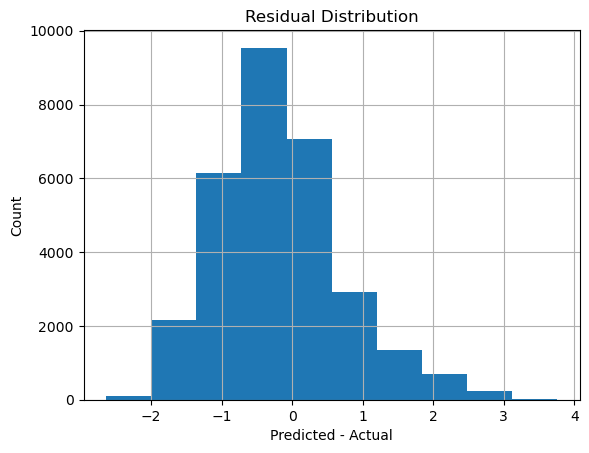

In [77]:
plt.hist(residuals)
plt.grid(True)
plt.xlabel('Predicted - Actual')
plt.ylabel('Count')
plt.title('Residual Distribution')
plt.show()

### Get Prediction for a single user and all movies

In [78]:
# load the one hot encoded svm for user 1

test_file = r'ml-latest-small/one_hot_enc_movies.svm'

In [80]:
df_one_user_test = pd.read_csv(test_file, sep=' ', names=['movieId','user_index','movie_index'])
df_one_user_test.user_index = df_one_user_test.user_index.map(lambda x: int(x.split(':')[0]))
df_one_user_test.movie_index = df_one_user_test.movie_index.map(lambda x: int(x.split(':')[0]))

In [81]:
df_one_user_test.head()

,movieId,user_index,movie_index
0,42011,0,6685
1,428,0,982
2,110,0,707
3,1097,0,1445
4,1073,0,1425


In [82]:
df_one_user_test.shape

(9724, 3)

In [83]:
%time
predictions = get_predictions(predictor, df_one_user_test[['user_index','movie_index']].values)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs
(9724, 2)
(98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), 

In [85]:
predictions[:5]

[3.407278299331665,
 3.86857271194458,
 4.379174709320068,
 4.0016279220581055,
 4.157388687133789]

In [86]:
df_one_user_test['ratins_predicted'] = predictions

In [87]:
df_one_user_test.head()

,movieId,user_index,movie_index,ratins_predicted
0,42011,0,6685,3.407278
1,428,0,982,3.868573
2,110,0,707,4.379175
3,1097,0,1445,4.001628
4,1073,0,1425,4.157389


In [88]:
df_movies = pd.read_csv(r'ml-latest-small/movies_genre.csv')

In [89]:
df_movies.head()

,Unnamed: 0,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [90]:
df_one_user_test = df_one_user_test.merge(df_movies, on='movieId')

In [93]:
df_one_user_test.drop(['Unnamed: 0'],axis=1,inplace=True)

In [95]:
df_one_user_test.head()

,movieId,user_index,movie_index,ratins_predicted,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,42011,0,6685,3.407278,Fun with Dick and Jane (2005),Comedy|Crime,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,428,0,982,3.868573,"Bronx Tale, A (1993)",Drama,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,110,0,707,4.379175,Braveheart (1995),Action|Drama|War,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,1097,0,1445,4.001628,E.T. the Extra-Terrestrial (1982),Children|Drama|Sci-Fi,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1073,0,1425,4.157389,Willy Wonka & the Chocolate Factory (1971),Children|Comedy|Fantasy|Musical,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0


### Recommendation List - ranked by predicted ratings

In [100]:
df_one_user_test.sort_values(['ratins_predicted'], ascending=False)[['title','ratins_predicted','genres']].head(10)

,title,ratins_predicted,genres
162,"Shawshank Redemption, The (1994)",4.664428,Crime|Drama
169,Schindler's List (1993),4.541071,Drama|War
399,Pulp Fiction (1994),4.527669,Comedy|Crime|Drama|Thriller
273,"Usual Suspects, The (1995)",4.513881,Crime|Mystery|Thriller
365,Star Wars: Episode IV - A New Hope (1977),4.497583,Action|Adventure|Sci-Fi
74,"Godfather, The (1972)",4.484547,Crime|Drama
455,Fight Club (1999),4.484356,Action|Crime|Drama|Thriller
136,"Silence of the Lambs, The (1991)",4.478573,Crime|Horror|Thriller
181,"Matrix, The (1999)",4.457962,Action|Sci-Fi|Thriller
234,Star Wars: Episode V - The Empire Strikes Back...,4.453864,Action|Adventure|Sci-Fi


### Comedy Movies recommendation list for an user

In [101]:
df_one_user_test[df_one_user_test['Comedy']==1]. \
    sort_values(['ratins_predicted'], ascending=False)[['title','ratins_predicted','genres']].head(10)

,title,ratins_predicted,genres
399,Pulp Fiction (1994),4.527669,Comedy|Crime|Drama|Thriller
75,Forrest Gump (1994),4.433508,Comedy|Drama|Romance|War
189,"Princess Bride, The (1987)",4.388137,Action|Adventure|Comedy|Fantasy|Romance
467,Fargo (1996),4.365031,Comedy|Crime|Drama|Thriller
906,Dr. Strangelove or: How I Learned to Stop Worr...,4.338766,Comedy|War
52,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",4.322893,Comedy|Romance
652,Monty Python and the Holy Grail (1975),4.310535,Adventure|Comedy|Fantasy
2014,Snatch (2000),4.301248,Comedy|Crime|Thriller
810,Office Space (1999),4.258981,Comedy|Crime
1377,Life Is Beautiful (La Vita è bella) (1997),4.253039,Comedy|Drama|Romance|War


### Drama Movies Recommendation list

In [102]:
df_one_user_test[df_one_user_test['Drama']==1]. \
    sort_values(['ratins_predicted'], ascending=False)[['title','ratins_predicted','genres']].head(10)

,title,ratins_predicted,genres
162,"Shawshank Redemption, The (1994)",4.664428,Crime|Drama
169,Schindler's List (1993),4.541071,Drama|War
399,Pulp Fiction (1994),4.527669,Comedy|Crime|Drama|Thriller
74,"Godfather, The (1972)",4.484547,Crime|Drama
455,Fight Club (1999),4.484356,Action|Crime|Drama|Thriller
75,Forrest Gump (1994),4.433508,Comedy|Drama|Romance|War
596,"Godfather: Part II, The (1974)",4.387659,Crime|Drama
422,"Lord of the Rings: The Return of the King, The...",4.385437,Action|Adventure|Drama|Fantasy
408,"Dark Knight, The (2008)",4.383984,Action|Crime|Drama|IMAX
2,Braveheart (1995),4.379175,Action|Drama|War


### Recommendation list for user 333

In [103]:
df_one_user_test.user_index=333

In [108]:
df_one_user_test.iloc[:5,:5]

,movieId,user_index,movie_index,ratins_predicted,title
0,42011,333,6685,3.407278,Fun with Dick and Jane (2005)
1,428,333,982,3.868573,"Bronx Tale, A (1993)"
2,110,333,707,4.379175,Braveheart (1995)
3,1097,333,1445,4.001628,E.T. the Extra-Terrestrial (1982)
4,1073,333,1425,4.157389,Willy Wonka & the Chocolate Factory (1971)


In [112]:
predictions = get_predictions(predictor, df_one_user_test[['user_index','movie_index']].values)
df_one_user_test['ratins_predicted']=predictions
df_one_user_test.sort_values(['ratins_predicted'], ascending=False)[['title','ratins_predicted','genres']].head(10)

(9724, 2)
(98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), 

,title,ratins_predicted,genres
162,"Shawshank Redemption, The (1994)",3.780969,Crime|Drama
169,Schindler's List (1993),3.672464,Drama|War
273,"Usual Suspects, The (1995)",3.647431,Crime|Mystery|Thriller
365,Star Wars: Episode IV - A New Hope (1977),3.646373,Action|Adventure|Sci-Fi
399,Pulp Fiction (1994),3.643799,Comedy|Crime|Drama|Thriller
75,Forrest Gump (1994),3.637346,Comedy|Drama|Romance|War
455,Fight Club (1999),3.621239,Action|Crime|Drama|Thriller
74,"Godfather, The (1972)",3.619444,Crime|Drama
136,"Silence of the Lambs, The (1991)",3.610834,Crime|Horror|Thriller
181,"Matrix, The (1999)",3.609025,Action|Sci-Fi|Thriller


### Recommendation list for user 209

In [113]:
df_one_user_test.user_index=209

In [114]:
df_one_user_test.iloc[:5,:5]

,movieId,user_index,movie_index,ratins_predicted,title
0,42011,209,6685,2.898455,Fun with Dick and Jane (2005)
1,428,209,982,3.222932,"Bronx Tale, A (1993)"
2,110,209,707,3.553562,Braveheart (1995)
3,1097,209,1445,3.305848,E.T. the Extra-Terrestrial (1982)
4,1073,209,1425,3.405426,Willy Wonka & the Chocolate Factory (1971)


In [115]:
predictions = get_predictions(predictor, df_one_user_test[['user_index','movie_index']].values)
df_one_user_test['ratins_predicted']=predictions
df_one_user_test.sort_values(['ratins_predicted'], ascending=False)[['title','ratins_predicted','genres']].head(10)

(9724, 2)
(98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (98, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), (97, 2), 

,title,ratins_predicted,genres
162,"Shawshank Redemption, The (1994)",4.292810,Crime|Drama
169,Schindler's List (1993),4.178694,Drama|War
399,Pulp Fiction (1994),4.154576,Comedy|Crime|Drama|Thriller
273,"Usual Suspects, The (1995)",4.152203,Crime|Mystery|Thriller
365,Star Wars: Episode IV - A New Hope (1977),4.146498,Action|Adventure|Sci-Fi
455,Fight Club (1999),4.125264,Action|Crime|Drama|Thriller
74,"Godfather, The (1972)",4.122692,Crime|Drama
136,"Silence of the Lambs, The (1991)",4.116873,Crime|Horror|Thriller
75,Forrest Gump (1994),4.115707,Comedy|Drama|Romance|War
181,"Matrix, The (1999)",4.107997,Action|Sci-Fi|Thriller


In [116]:
# Delete the endpoint
predictor.delete_endpoint()